In [22]:
import sys
sys.path.append('..')

In [23]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from CommonFunctions import *
%matplotlib inline

Import the data

In [24]:
dataset = pd.read_csv('monthly_in_situ_co2_mlo.csv', 
                      comment='"', na_values='-99.99', header=[0])
cols = []
for col1, col2, col3 in zip(dataset.columns.values, dataset.iloc[0].values, dataset.iloc[1].values):
    column_name = col1.replace(' ', '')
    for col in [str(c).replace(' ', '') for c in [col2, col3]]:
        column_name += f'_{col}' if col not in ['', 'nan'] else ''
    cols.append(column_name)
dataset = dataset.set_axis(cols, axis=1).iloc[2:].reset_index(drop=True)
dataset.Date = dataset.Yr + '-' + dataset.Mn.apply(lambda x: x.replace(' ', '')).values
dataset.index = pd.to_datetime(dataset.Date, format='%Y-%m')
dataset = dataset['CO2_filled_[ppm]']
dataset.rename('CO2', inplace=True)
dataset = dataset.apply(lambda x: float(x.replace(' ', '')))
dataset.replace(to_replace=-99.99, value=float('nan'), inplace=True)
dataset.interpolate(method='linear', axis=0, inplace=True)
dataset = dataset.iloc[2:]
dataset

Date
1958-03-01    315.71
1958-04-01    317.45
1958-05-01    317.51
1958-06-01    317.27
1958-07-01    315.87
               ...  
2024-08-01    425.22
2024-09-01    425.22
2024-10-01    425.22
2024-11-01    425.22
2024-12-01    425.22
Name: CO2, Length: 802, dtype: float64

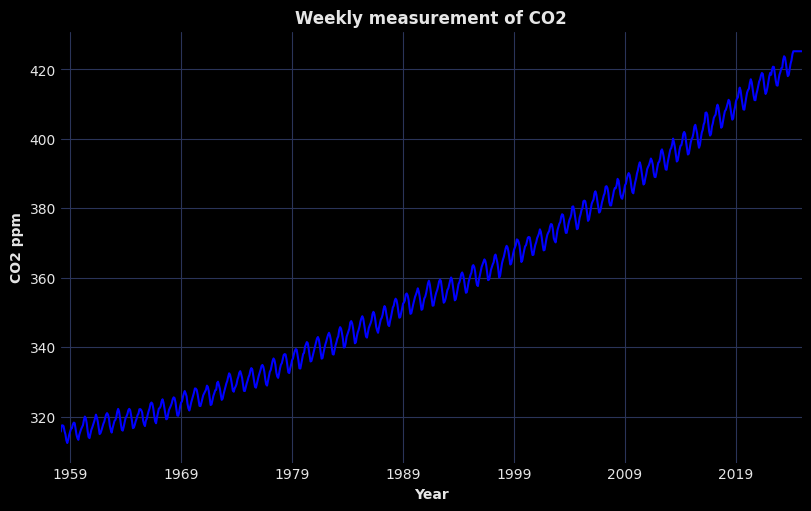

In [25]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset.plot(ax=axes, color='blue')
    axes.set(title='Weekly measurement of CO2', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)

## Adding lagged components

In [26]:
def create_lag_features(data: pd.DataFrame, lag: int = 1) -> pd.DataFrame:
    df = pd.DataFrame(data)
    column = df.columns[0]
    for i in range(lag):
        df[f'lag_{i}'] = df[column].shift(i)
    return df.dropna()

In [27]:
dataset = create_lag_features(dataset, lag=15)
dataset.head(10).iloc[:, :5]

,CO2,lag_0,lag_1,lag_2,lag_3
Date,,,,,
1959-05-01,318.29,318.29,317.72,316.65,316.49
1959-06-01,318.15,318.15,318.29,317.72,316.65
1959-07-01,316.54,316.54,318.15,318.29,317.72
1959-08-01,314.80,314.80,316.54,318.15,318.29
1959-09-01,313.84,313.84,314.80,316.54,318.15
1959-10-01,313.33,313.33,313.84,314.80,316.54
1959-11-01,314.81,314.81,313.33,313.84,314.80
1959-12-01,315.58,315.58,314.81,313.33,313.84
1960-01-01,316.43,316.43,315.58,314.81,313.33


Splitting the data

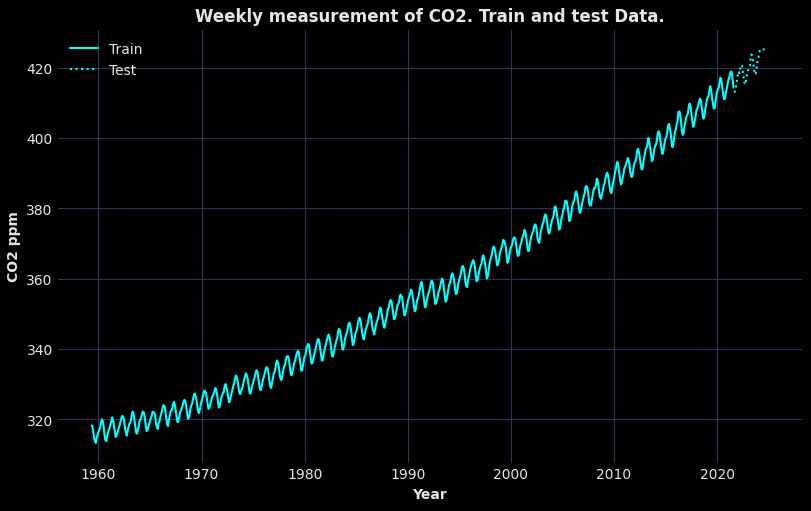

In [28]:
split_ratio = 0.95
split_part = int(len(dataset) * split_ratio)
data_train = dataset.iloc[:split_part]
data_test = dataset.iloc[split_part:]

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(data_train.iloc[:, 0], color='cyan', label='Train')
    axes.plot(data_test.iloc[:, 0], color='cyan', label='Test', linestyle=':')
    axes.set(title='Weekly measurement of CO2. Train and test Data.', xlabel='Year', ylabel='CO2 ppm')
    axes.legend()
    enhance_plot(figure, axes)
    figure.savefig('images/Split.png')

## Random Forest Regressor

In [29]:
X_train = data_train.iloc[:, 1:]
y_train = data_train.iloc[:, 0]
X_test = data_test.iloc[:, 1:]
y_test = data_test.iloc[:, 0]
parameters_to_choose_rfr = {
    'n_estimators': [200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3]
}
rfr = RandomForestRegressor(random_state=42)

Finding the best parameters

In [30]:
grid_search_rfr = GridSearchCV(estimator=rfr,
                               param_grid=parameters_to_choose_rfr,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)
best_params_rfr = grid_search_rfr.best_params_
best_params_rfr

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [31]:
rfr_model = RandomForestRegressor(**best_params_rfr, random_state=42)
rfr_model.fit(X_train, y_train)
y_pred_rfr = rfr_model.predict(X_test)
error_rfr = mean_absolute_percentage_error(y_test, y_pred_rfr) * 100
error_rfr

0.6787979978878406

## Gradient Boosting Regressor

In [32]:
parameters_to_choose_gbr = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.05],
    'max_depth': [3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'subsample': [0.9, 1.0]
}
gbr = GradientBoostingRegressor(random_state=42)
grid_search_gbr = GridSearchCV(estimator=gbr,
                               param_grid=parameters_to_choose_gbr,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)
best_params_gbr = grid_search_gbr.best_params_
best_params_gbr

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1500,
 'subsample': 1.0}

In [33]:
gbr_model = GradientBoostingRegressor(**best_params_gbr, random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
error_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr) * 100
error_gbr

0.6085548932307585

## Extreme Gradient Boosting Regressor

In [34]:
parameters_to_choose_xgb = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 5, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=parameters_to_choose_xgb,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 1500,
 'subsample': 0.9}

In [37]:
xgb_model = XGBRegressor(**best_params_xgb, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
error_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100
error_xgb

0.7041627155468947

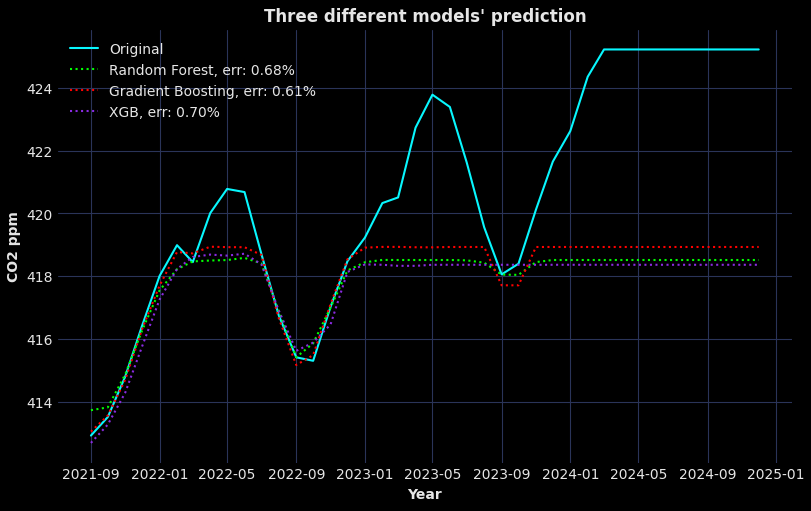

In [36]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(y_test.index, y_test, label='Original')
    axes.plot(y_test.index, y_pred_rfr, color='lime', linestyle=':',
              label=f'Random Forest, err: {error_rfr:.2f}%')
    axes.plot(y_test.index, y_pred_gbr, color='red', linestyle=':',
              label=f'Gradient Boosting, err: {error_gbr:.2f}%')
    axes.plot(y_test.index, y_pred_xgb, color='blueviolet', linestyle=':',
              label=f'XGB, err: {error_xgb:.2f}%')
    axes.legend()
    axes.set(title='Three different models\' prediction', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)
    figure.savefig('images/Prediciton.png')

All models perform similarly. They are the best for predicting first period of the data. After that in converges to a single value.